I am using a polytropic equation of state, which is defined as

$$ P(\rho) = \Kappa\rho^\frac{n+1}{n} = \Kappa\rho^{1 + \frac{1}{n}} $$

For now, I'm just going to use the EOS

$$ P(\varepsilon) = \Kappa\varepsilon^\gamma  $$

This equation can also be expressed as 

$$ \varepsilon(P) = \left(\frac{P}{\Kappa}\right)^\frac{1}{\gamma} $$

or 

$$ \Kappa = \frac{P}{\varepsilon^\gamma} $$

To find $\gamma$, I used the fact that K is a constant to set the equations for K equal to each other at two different points.

$$ P_1(\varepsilon) = \Kappa (\varepsilon_1)^\gamma $$
$$ \Kappa = \frac{P_1}{(\varepsilon_1)^\gamma} $$

and

$$ P_2(\varepsilon) = \Kappa (\varepsilon_2)^\gamma $$
$$ \Kappa = \frac{P_2}{(\varepsilon_2)^\gamma} $$

then 

$$ \Kappa = \frac{P_1}{(\varepsilon_1)^\gamma} = \frac{P_2}{(\varepsilon_2)^\gamma} $$
$$ \log\left(\frac{P_1}{(\varepsilon_1)^\gamma}\right) = \log\left(\frac{P_2}{(\varepsilon_2)^\gamma}\right) $$
$$ \log(P_1) - \gamma \log(\varepsilon_1) = \log(P_2) - \gamma \log(\varepsilon_2) $$
$$ \gamma \log(\varepsilon_2) - \gamma \log(\varepsilon_1) = \log(P_2) - \log(P_1) $$
$$ \gamma (\log(\varepsilon_2) - \log(\varepsilon_1)) = \log(P_2) - \log(P_1) $$
$$ \gamma = \frac{\log(P_2) - \log(P_1)}{\log(\varepsilon_2) - \log(\varepsilon_1)} $$
$$ \gamma = \frac{\log(\frac{P_2}{P_1})}{\log(\frac{\varepsilon_2}{\varepsilon_1})} $$

In [1]:
from math import log10

import numpy as np

def gamma(point_1: tuple[float, float], point_2: tuple[float, float]) -> float: 
    '''
    Calculates gamma given two points in the form (energy density, pressure).
    '''
    e_1, p_1 = point_1
    e_2, p_2 = point_2
    return log10(p_2 / p_1) / log10(e_2 / e_1)

def kappa(point_1: tuple[float, float], point_2: tuple[float, float], gamma: float) -> float:
    '''
    Calculates kappa given the pressure and energy density. Since these are estimations, 
    takes the average of the two resulting kappa values to reduce error. 
    '''
    e_1, p_1 = point_1
    e_2, p_2 = point_2
    k_1 = p_1 / (e_1 ** gamma)
    k_2 = p_2 / (e_2 ** gamma)
    return (k_1 + k_2) / 2

# Constants
epsilon_1 = 10**2
epsilon_2 = 1.8 * (10**2)
# Upper Bound
ub_1 = (epsilon_1, 1)
ub_2 = (epsilon_2, 3.5)
gamma_ub = gamma(ub_1, ub_2)
kappa_ub = kappa(ub_1, ub_2, gamma_ub)
print(f"Upper Bound Gamma: {gamma_ub}")
print(f"Upper Bound Kappa: {kappa_ub}")
print("----------------------------------------")

# Midline
m_1 = (epsilon_1, 0.6)
m_2 = (epsilon_2, 2.8)
gamma_m = gamma(m_1, m_2)
kappa_m = kappa(m_1, m_2, gamma_m)
print(f"Midline Gamma: {gamma_m}")
print(f"Midline Kappa: {kappa_m}")
print("----------------------------------------")


# Lower Bound
lb_1 = (epsilon_1, 0.2)
lb_2 = (epsilon_2, 2)
gamma_lb = gamma(lb_1, lb_2)
kappa_lb = kappa(lb_1, lb_2, gamma_lb)
print(f"Lower Bound Gamma: {gamma_lb}")
print(f"Lower Bound Kappa: {kappa_lb}")
print("----------------------------------------")

# Averages
gamma_avg = np.average([gamma_ub, gamma_m, gamma_lb]) 
kappa_avg = np.average([kappa_ub, kappa_m, kappa_lb])
print(f"Average Gamma: {gamma_avg}")
print(f"Average Kappa: {kappa_avg}")

Upper Bound Gamma: 2.131322541493833
Upper Bound Kappa: 5.4620405123884e-05
----------------------------------------
Midline Gamma: 2.620755340211182
Midline Kappa: 3.4406505837560548e-06
----------------------------------------
Lower Bound Gamma: 3.9173823267621817
Lower Bound Kappa: 2.925939501457162e-09
----------------------------------------
Average Gamma: 2.8898200694890654
Average Kappa: 1.935466054904717e-05


Using energy density, $\varepsilon$ where $m_r(r)$ is the mass enclosed in a radius, $\rho(r)$ is the density at some radius r, and
$P(r)$ is the pressure at radius $r$.

$$
\frac{dm_r}{dr} = 4\pi r^2 \varepsilon(r)
$$

$$
\frac{dP}{dr}=
    -G\frac{m_r(r)\varepsilon(r)}{r^2}
    \left(1+\frac{P(r)}{\varepsilon(r)}\right)
    \left(1+\frac{4\pi r^3 P(r)}{m_r(r)}\right)
    \left(1-\frac{2 Gm_r(r)}{r}\right)^{-1}
$$

$r$ = radius.

$m_r(r)$ = the radius enclosed within a radius $r$.

$P(r)$ = the pressure at radius $r$.

$\varepsilon$ = energy density at radius $r$.

$G$ = gravitational constant.



In [2]:
import numpy as np
from scipy.constants import G, pi
from scipy.integrate import solve_ivp

def energy_density(p):
    '''
    Calculates the energy density as a function of pressure using estimated midline values for kappa and gamma.
    '''
    K = kappa_m
    gamma = gamma_m
    return (p / K) ** (1 / gamma)

def pressure(r):
    ...

def tov_rhs(r, state):
    '''
    Returns [dP/dr, dm/dr].
    '''
    # Pressure, mass, and density at the current radius
    p_r, m_r = state
    e_r = energy_density(p_r)
    # Mass 
    dm_dr = 4*pi * r**2 * e_r
    # Pressure (split into factors)
    f1 = -G * ((m_r * e_r) / (r**2))
    f2 = 1 + (p_r / e_r)
    f3 = 1 + ((4*pi * r**3 * p_r) / m_r)
    f4 = (1 - ((2*G*m_r) / r)) ** -1
    dp_dr = f1 * f2 * f3 * f4
    return [dp_dr, dm_dr]

# TODO: Find valid values for these
# The interval one which to evaluate solve_ivp()
R_0 = 1.01 # 10 m
R_START = 1 # 1 km
R_END = 20 # 20 km
r_points = np.linspace(R_START, R_END, num=100)
# Central pressure.
P_C = 1 # MeV/fm^3 ?
# Central enclosed mass.
M_0 = 0.1 # Solar Masses?

def solve():
    return solve_ivp(
        tov_rhs,
        t_span=(R_START, R_END),
        t_eval=r_points,
        y0=(P_C, M_0)
    )

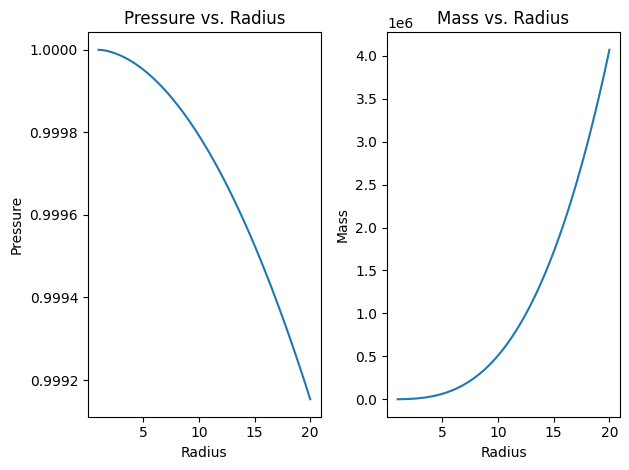

In [3]:
from matplotlib.axes import Axes
from matplotlib.figure import Figure
import matplotlib.pyplot as plt

solutions = solve()
r_solutions = solutions.t
p_solutions = solutions.y[0]
m_solutions = solutions.y[1]

subplots: tuple[Figure, tuple[Axes, Axes]] = plt.subplots(1, 2)
fig, (ax1, ax2) = subplots

ax1.set_title("Pressure vs. Radius")
ax1.set_ylabel("Pressure")
ax1.set_xlabel("Radius")
ax1.plot(r_solutions, p_solutions)

ax2.set_title("Mass vs. Radius")
ax2.set_ylabel("Mass")
ax2.set_xlabel("Radius")
ax2.plot(r_solutions, m_solutions)

fig.tight_layout()
plt.show()